In [1]:
import glob
import random

import geopandas as gpd
import laspy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    mean_absolute_error,
    r2_score,
    root_mean_squared_error,
)
from sklearn.model_selection import cross_val_predict, cross_validate, train_test_split
from sklearn.pipeline import make_pipeline

from src.clouds import dropout_low_points_sigmoid

In [2]:
file_paths = glob.glob("../data/raw/trees/**/*.las")
file_paths.sort()

data = pd.DataFrame({"path": file_paths})
data["species"] = data["path"].map(lambda p: p.split("/")[-2])

In [3]:
data.shape

(394, 2)

In [4]:
data.head(n=3)

,path,species
0,../data/raw/trees/Alder/alder_00.las,Alder
1,../data/raw/trees/Alder/alder_01.las,Alder
2,../data/raw/trees/Alder/alder_02.las,Alder


In [5]:
def compute_cloud_features(
    path: str,
    *,
    height_threshold: float = 2.0,
    repeat=10,
) -> dict:
    las = laspy.read(path)
    rng = np.random.default_rng()
    for i in range(repeat):
        out = {}
        (xyz,) = dropout_low_points_sigmoid(
            las.xyz,
            scale=18,
            shift=2.5,
        )
        jitter = rng.uniform(low=-0.2, high=+0.2, size=xyz.shape)
        xyz += jitter
        X, Y, Z = np.rollaxis(xyz, axis=1)

        height_mask = Z > height_threshold
        X, Y, Z = X[height_mask], Y[height_mask], Z[height_mask]

        # Height distribution features (Woods et al., 2008)
        out.update(
            {
                "z_max": Z.max(),
                "z_mean": Z.mean(),
                "z_std": Z.std(),
                "z_skew": scipy.stats.skew(Z),
                "z_kurt": scipy.stats.kurtosis(Z),
                "z_entropy": scipy.stats.entropy(Z),
                "pct_z_above_mean": np.mean(Z > Z.mean()),
                "pct_z_above_2": np.mean(Z > 2),
            }
        )

        for i, z in enumerate(np.percentile(Z, range(10, 100, 10)), 1):
            out.update({f"z_decile_{i}": z})

        counts, bins = np.histogram(Z, bins=np.linspace(Z.min(), Z.max(), 11))
        counts = np.cumsum(counts / Z.size)[:-1]
        for i, c in enumerate(counts, 1):
            out.update({f"z_cumrat_{i}": c})

        # Eigenvalue features (Lucas et al., 2019)
        covariance_matrix = np.cov(las.xyz, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
        lambda1, lambda2, lambda3 = sorted(eigenvalues, reverse=True)

        out.update(
            {
                "linearity": (lambda1 - lambda2) / lambda1,
                "planarity": (lambda2 - lambda3) / lambda1,
                "scatter": lambda3 / lambda1,
                "omnivariance": np.cbrt(lambda1 * lambda2 * lambda3),
                "eigentropy": -lambda1 * np.log(lambda1)
                - lambda2 * np.log(lambda2)
                - lambda3 * np.log(lambda3),
                "sum_of_eigenvalues": lambda1 + lambda2 + lambda3,
                "curvature": lambda3 / (lambda1 + lambda2 + lambda3),
            }
        )

        yield out

In [6]:
%%time

train, test = train_test_split(data, test_size=0.4)

features_train = []
for i, row in train.iterrows():
    for x in compute_cloud_features(path=row["path"], repeat=5):
        x["label"] = row["species"]
        features_train.append(x)

features_test = []
for i, row in test.iterrows():
    for x in compute_cloud_features(path=row["path"], repeat=1):
        x["label"] = row["species"]
        features_test.append(x)

features_train = pd.json_normalize(features_train)
features_test = pd.json_normalize(features_test)

X_train = features_train.copy()
y_train = X_train.pop("label")

X_test = features_test.copy()
y_test = X_test.pop("label")

CPU times: user 1.11 s, sys: 35.3 ms, total: 1.14 s
Wall time: 1.26 s


In [7]:
test.shape

(158, 2)

In [8]:
%%time

sfs = SequentialFeatureSelector(
    estimator=RandomForestClassifier(n_estimators=100),
    n_features_to_select=10,
)
sfs.fit(X=X_train, y=y_train)

CPU times: user 2min 14s, sys: 832 ms, total: 2min 15s
Wall time: 2min 15s


SequentialFeatureSelector(estimator=RandomForestClassifier(),
                          n_features_to_select=10)

In [9]:
clf = make_pipeline(
    RandomForestClassifier(
        n_estimators=200,
        class_weight="balanced",
    ),
)

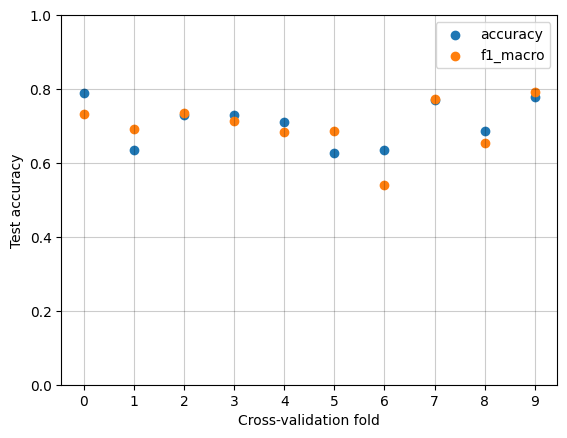

In [10]:
#| include: true
#| label: fig-cv-clf
#| fig-cap: 10-fold cross-validation results of the species classification Random Forest
#|   model. The average accuracy is 0.71 with a standard deviation of 0.06. The average
#|   macro F-score is 0.70 with a standard deviation of 0.07. The model is overall stable
#|   across all of the folds.

metrics = ["accuracy", "f1_macro"]

cv_result = cross_validate(
    estimator=clf,
    X=sfs.transform(X_train),
    y=y_train,
    cv=10,
    scoring=metrics,
)

fig, ax = plt.subplots()
for metric in metrics:
    ax.scatter(range(10), cv_result[f"test_{metric}"], label=metric)
ax.set_ylim(0, 1)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set_xlabel("Cross-validation fold")
ax.set_ylabel("Test accuracy")
ax.legend()
ax.grid(alpha=0.2, color="k")

In [11]:
for k, v in cv_result.items():
    print(f"{k:>15}: {v.mean():.2f} +- {v.std():.2f}")

       fit_time: 0.26 +- 0.00
     score_time: 0.01 +- 0.00
  test_accuracy: 0.71 +- 0.06
  test_f1_macro: 0.70 +- 0.07


In [12]:
clf.fit(sfs.transform(X_train), y_train)
pred = clf.predict(sfs.transform(X_test))

In [13]:
accuracy_score(y_test, pred)

0.6075949367088608

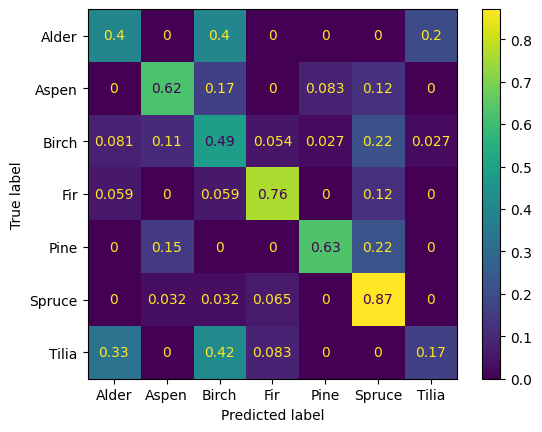

In [14]:
#| include: true
#| label: fig-clf-confusion-matrix
#| fig-cap: |
#|   Confusion matrix for the tree species classification Random Forest. Calulated on 
#|   the 40% holdout set of 158 examples. Values normalized by row. The model confuses
#|   deciduous species a lot more than coniferous ones.

cm = ConfusionMatrixDisplay.from_predictions(y_test, pred, normalize="true")

---

In [15]:
fi = gpd.read_file("../data/interim/lysva/field_survey.geojson")

data = pd.DataFrame({"path": file_paths})
data["species"] = data["path"].map(lambda p: p.split("/")[-2])

data["file"] = data["path"].str.split("/").str.get(-1)
data = pd.merge(
    left=data,
    right=fi[["las_file", "dbh"]],
    left_on="file",
    right_on="las_file",
    how="inner",
)

data.head()

,path,species,file,las_file,dbh
0,../data/raw/trees/Alder/alder_00.las,Alder,alder_00.las,alder_00.las,27.75
1,../data/raw/trees/Alder/alder_01.las,Alder,alder_01.las,alder_01.las,23.60
2,../data/raw/trees/Alder/alder_02.las,Alder,alder_02.las,alder_02.las,31.60
3,../data/raw/trees/Alder/alder_03.las,Alder,alder_03.las,alder_03.las,31.20
4,../data/raw/trees/Alder/alder_04.las,Alder,alder_04.las,alder_04.las,26.65


In [16]:
%%time

train, test = train_test_split(data, test_size=0.4)

features_train = []
for i, row in train.iterrows():
    for x in compute_cloud_features(path=row["path"], repeat=5):
        x["label"] = row["dbh"]
        features_train.append(x)

features_test = []
for i, row in test.iterrows():
    for x in compute_cloud_features(path=row["path"], repeat=1):
        x["label"] = row["dbh"]
        features_test.append(x)

features_train = pd.json_normalize(features_train)
features_test = pd.json_normalize(features_test)

X_train = features_train.copy()
y_train = X_train.pop("label")

X_test = features_test.copy()
y_test = X_test.pop("label")

CPU times: user 436 ms, sys: 14 ms, total: 450 ms
Wall time: 450 ms


In [17]:
test.shape

(68, 5)

In [18]:
%%time

sfs = SequentialFeatureSelector(
    estimator=RandomForestRegressor(n_estimators=100),
    n_features_to_select=10,
)
sfs.fit(X=X_train, y=y_train)

CPU times: user 2min, sys: 1.1 s, total: 2min 2s
Wall time: 2min 2s


SequentialFeatureSelector(estimator=RandomForestRegressor(),
                          n_features_to_select=10)

In [19]:
reg = make_pipeline(
    RandomForestRegressor(
        n_estimators=200,
    ),
)

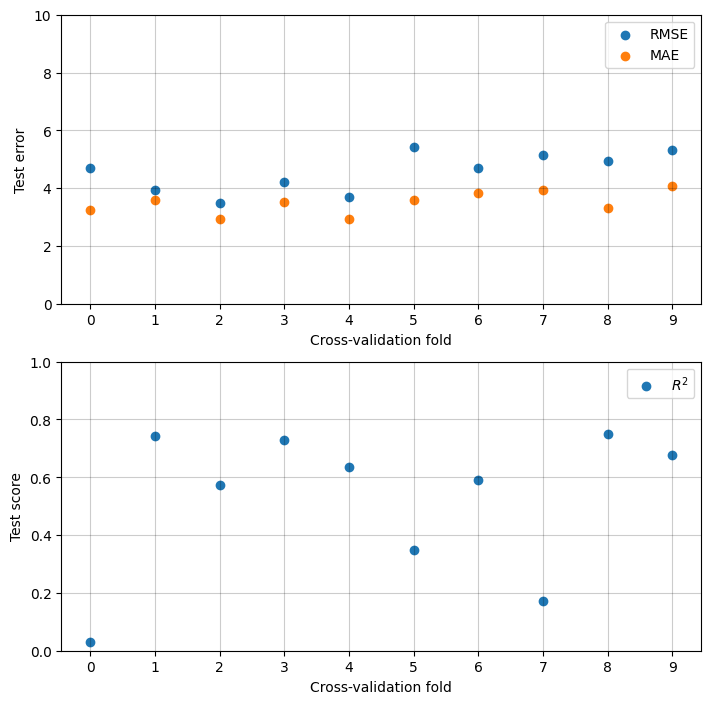

In [20]:
#| include: true
#| label: fig-cv-reg
#| fig-cap: |
#|   10-fold cross-validation results of the dbh regression Random Forest model. The
#|   average RMSE is 4.55 centimeters with a standard deviation of 0.19. The average MAE 
#|   is 3.49 centimeters with a standard deviation of 0.38. The average coefficient of
#|   determination $R^2$ is 0.53 with a standard deviation of 0.24. The model is
#|   relatively stable in terms of the errors, but the coefficient of determination is
#|   all over the place.

metrics = [
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "r2",
]  # add r2 and make graph manually

cv_result = cross_validate(
    estimator=reg,
    X=sfs.transform(X_train),
    y=y_train,
    cv=10,
    scoring=metrics,
)

fig, axes = plt.subplots(2, 1, figsize=(8.26, 8.26))

ax = axes[0]
ax.scatter(range(10), cv_result["test_neg_root_mean_squared_error"] * -1, label="RMSE")
ax.scatter(range(10), cv_result["test_neg_mean_absolute_error"] * -1, label="MAE")
ax.set_ylabel("Test error")
ax.set_ylim(0, 10)

ax = axes[1]
ax.scatter(range(10), cv_result["test_r2"], label="$R^2$")
ax.set_ylabel("Test score")
ax.set_ylim(0, 1)

for ax in axes:
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
    ax.set_xlabel("Cross-validation fold")
    ax.legend()
    ax.grid(alpha=0.2, color="k")

In [21]:
for k, v in cv_result.items():
    print(f"{k:>15}: {v.mean():.2f} +- {v.std():.2f}")

       fit_time: 0.27 +- 0.01
     score_time: 0.00 +- 0.00
test_neg_root_mean_squared_error: -4.55 +- 0.65
test_neg_mean_absolute_error: -3.49 +- 0.38
        test_r2: 0.53 +- 0.24


In [22]:
reg.fit(sfs.transform(X_train), y_train)
pred = reg.predict(sfs.transform(X_test))

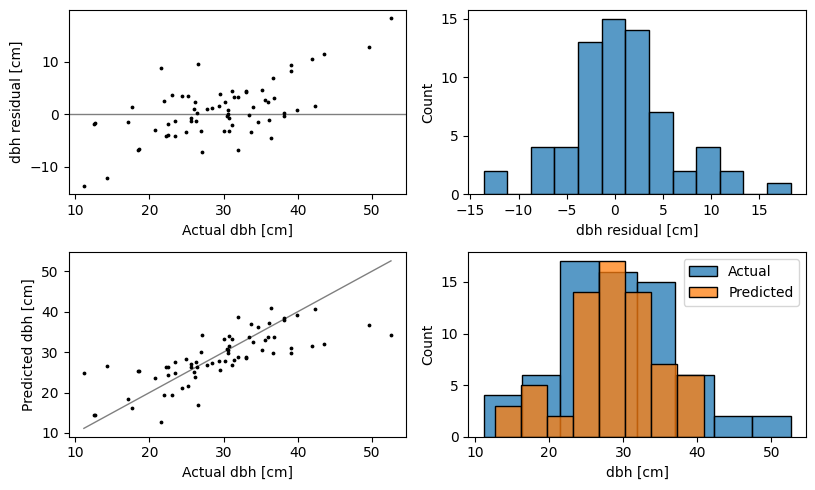

In [23]:
#| include: true
#| label: fig-reg-residuals
#| fig-cap: |
#|   Quality assessment plots for the diameter at breast height regression Random Forest.
#|   Calculated on a 40% holdout set of 68 examples.
#|   **Top Left:** Residual scatter plot: difference between the prediction and the true 
#|   value vs. the true value. Ideally the spread should be equal across the valu range.
#|   **Bottom Left:** Predicted vs. actual scatter plot. Ideally should be as close to a
#|   line as possible.
#|   **Top right:** Distribution of the residuals.
#|   **Bottom right:** Distribution of the predicted and actual values of dbh.

fig = plt.figure(figsize=(8.26, 5), tight_layout=True)

ax = fig.add_subplot(221)
ax.scatter(y_test, y_test - pred, c="k", s=3)
ax.axhline(0, c="k", lw=1, alpha=0.5)
ax.set_xlabel("Actual dbh [cm]")
ax.set_ylabel("dbh residual [cm]")

ax = fig.add_subplot(223)
ax.scatter(y_test, pred, c="k", s=3)
lims = [y_test.min(), y_test.max()]
ax.plot(lims, lims, c="k", lw=1, alpha=0.5)
ax.set_xlabel("Actual dbh [cm]")
ax.set_ylabel("Predicted dbh [cm]")

ax = fig.add_subplot(222)
sns.histplot(x=y_test - pred, ax=ax)
ax.set_xlabel("dbh residual [cm]")

ax = fig.add_subplot(224)
sns.histplot(x=y_test, ax=ax, label="Actual")
sns.histplot(x=pred, ax=ax, label="Predicted")
ax.set_xlabel("dbh [cm]")
ax.legend();

In [24]:
mean_absolute_error(y_test, pred)

np.float64(4.11627205882353)

In [25]:
root_mean_squared_error(y_test, pred)

np.float64(5.764844338589005)

In [26]:
r2_score(y_test, pred)

0.520740603745083

In [27]:
import pickle

with open("../models/tree-species-classifier.pickle", "bw") as f:
    pickle.dump(clf, f)

with open("../models/tree-dbh-regressor.pickle", "bw") as f:
    pickle.dump(reg, f)